# simple t-test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import matplotlib
from IPython.display import display, HTML, Image

import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

In [3]:
from linker.models import Analysis
from linker.views import get_last_data
from linker.views.pipelines import WebOmicsInference
from linker.constants import *

ModuleNotFoundError: No module named 'linker'

### Load test data

In [4]:
def get_dataframes(analysis_data, pk_col, sample_col):
    data_df = pd.DataFrame(analysis_data.json_data).set_index(pk_col)
    design_df = None
    if analysis_data.json_design:
        design_df = pd.DataFrame(analysis_data.json_design).set_index(sample_col)
    return data_df, design_df

In [5]:
analysis_id = 155
analysis = Analysis.objects.get(pk=analysis_id)
data = {}
design = {}
for k, v in DataRelationType:
    try:
        analysis_data = get_last_data(analysis, k)
        data_df, design_df = get_dataframes(analysis_data, PKS[k], SAMPLE_COL)
        data[k] = data_df
        design[k] = design_df
    except IndexError:
        continue
    except KeyError:
        continue

### Plot heatmap

In [6]:
data_type = GENOMICS
min_value = 0
data_df = data[data_type]
design_df = design[data_type]

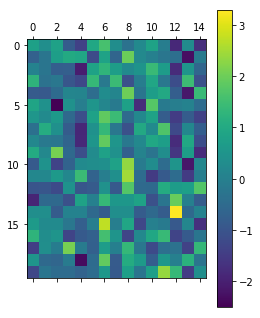

In [8]:
inference = WebOmicsInference(data_df, design_df, data_type, min_value=min_value)
inference.heatmap(N=20, standardize=True, log=False)

In [9]:
data_type = METABOLOMICS
min_value = 5000
data_df = data[data_type]
design_df = design[data_type]

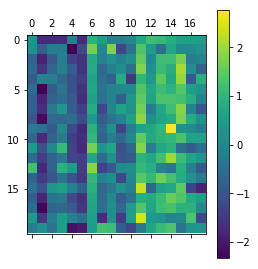

In [10]:
inference = WebOmicsInference(data_df, design_df, data_type, min_value=min_value)
inference.heatmap(N=20, standardize=True, log=True)

### Run t-test

In [23]:
case = 'Distal'
control = 'Proximal'

In [25]:
inference = WebOmicsInference(data_df, design_df, data_type, min_value=min_value)
inference.run_ttest(case, control)

,padj,log2FoldChange
16244,0.003078,-1.648085
20067,0.067510,-0.399556
C00008,0.005531,-0.957702
C00015,0.017392,-0.994787
C00020,0.019252,-1.509561
C00025,0.001228,-1.219235
C00026,0.000971,-1.516124
C00035,0.055420,-1.023484
C00036,0.002114,-1.480834
C00037,0.027234,-1.221986
